In [1]:
## remember to run conn_cocolab from the terminal before running cells in this notebook!

import os
import urllib, cStringIO

import pymongo as pm

import matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')

import numpy as np
from __future__ import division
import scipy.stats as stats
import pandas as pd
import json
import re

from PIL import Image
import base64
import datetime

In [2]:
# categories = [i for i in os.listdir('sketches') if i != '.DS_Store']
# num_ims = 0
# ims_per_cat = []
# for c in categories:
#     num_ims += len([i for i in os.listdir(os.path.join('sketches',c)) if i != '.DS_Store'])
#     ims_per_cat.append(len([i for i in os.listdir(os.path.join('sketches',c)) if i != '.DS_Store']))
    
# print num_ims
# print ims_per_cat

### file hierarchy and database connection vars

In [3]:
# directory & file hierarchy
iterationName = 'cdm_run_v3'
exp_path = 'museumstation'
analysis_dir = os.getcwd()
exp_dir = os.path.abspath(os.path.join(os.getcwd(),'../..','experiments'))
##
sketch_dir = os.path.join(analysis_dir,'sketches')
if not os.path.exists(sketch_dir):
    os.makedirs(sketch_dir)
## dir where we can keep all sketches not binned by category    


In [4]:
# set vars 
auth = pd.read_csv('../auth.txt', header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'rxdhawkins.me' ## cocolab ip address

# have to fix this to be able to analyze from local
import pymongo as pm
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')
db = conn['kiddraw']
coll = db['cdm_run_v3']

### Preprocessing data and rendering images

Notes:
There are two types of records in the database: 'stroke' and 'finalImage'. This is stored under the key: 'dataType'.
The 'stroke'-type of record contains the svg string information. Every stroke event is stored as a separate record.
The session identifier is called "sessionId".




In [5]:
experiment_name = 'cdm_run_v3'
time_threshold = 1510252452134 ## this is the timepoint after which real data started getting collected
all_sessions = coll.distinct('sessionId') ## this returns ALL sessions in this collection. we will then filter on time_threshold
valid_sessions = coll.find({'time':{'$gt': time_threshold}}).distinct('sessionId')
image_recs_all = coll.find({'$and': [{'dataType':'finalImage'}]})
numImages = image_recs_all.count()
lastImage = image_recs_all[numImages - 1]
lastestDate = lastImage['date']

print 'We currently have {} valid sessions from {}.'.format(len(valid_sessions), iterationName)
print 'We currently have {} total drawings from {}.'.format(numImages, iterationName)
print 'The last drawing was made at {}.'.format(lastestDate)

We currently have 4412 valid sessions from cdm_run_v3.
We currently have 25160 total drawings from cdm_run_v3.
The last drawing was made at 2018-09-04T21:33:25.905Z.


### How many of these drawings are from kids and not on practice trials?

In [6]:
image_recs_kids = coll.find({'$and': [{'dataType':'finalImage'},{'age':{"$ne": 'adult'}},{'category':'square'}]})
print 'We currently have {} square images from kids in {}.'.format(image_recs_kids.count(), iterationName)

image_recs_kids = coll.find({'$and': [{'dataType':'finalImage'},{'age':{"$ne": 'adult'}},{'category':'shape'}]})
print 'We currently have {} shape images from kids in {}.'.format(image_recs_kids.count(), iterationName)

image_recs_kids = coll.find({'$and': [{'dataType':'finalImage'},{'age':{"$ne": 'adult'}},{'category':'this circle'}]})
print 'We currently have {} circle images from kids in {}.'.format(image_recs_kids.count(), iterationName)

image_recs_kids = coll.find({'$and': [{'dataType':'finalImage'},{'age':{"$ne": 'adult'}}]})
print 'We currently have {} TOTAL images from kids in {}.'.format(image_recs_kids.count(), iterationName)


We currently have 3969 square images from kids in cdm_run_v3.
We currently have 3036 shape images from kids in cdm_run_v3.
We currently have 2462 circle images from kids in cdm_run_v3.
We currently have 22812 TOTAL images from kids in cdm_run_v3.


In [7]:
image_recs_kids_not_practice = coll.find({'$and': [{'dataType':'finalImage'},{'age':{"$ne": 'adult'}},{'category':{"$nin": ['square','this circle','shape']}}]})
print 'We currently have {} non-practice trials from kids in {}.'.format(image_recs_kids_not_practice.count(), iterationName)

We currently have 13345 non-practice trials from kids in cdm_run_v3.


In [9]:
image_recs_adults_not_practice = coll.find({'$and': [{'dataType':'finalImage'},{'age': 'adult'},{'category':{"$nin": ['square','this circle','shape']}}]})
print 'We currently have {} non-practice trials from adults in {}.'.format(image_recs_adults_not_practice.count(), iterationName)

We currently have 1357 non-practice trials from adults in cdm_run_v3.


### Get out number of drawings per age and class

In [12]:
ages = {'age2','age3','age4','age5','age6','age7','age8','age9','age10','adult'}
# categories_run1 = {
# 'a boat',
# 'a car',
# 'a cup',
# 'a dog',
# 'a fish',
# 'a house',
# 'a person',
# 'a tree'}

# categories_run2 = {'an airplane',
# 'a bike',
# 'a bird',
# 'a bowl',
# 'a chair',
# 'a couch',
# 'a phone',
# 'a rabbit'}


categories = {
'an airplane',
'a bike',
'a bird',
'a bowl',
'a chair',
'a couch',
'a phone',
'a rabbit',
'a boat',
'a car',
'a cup',
'a dog',
'a fish',
'a house',
'a person',
'a tree'}

animalgame_categories = {
'a bird',
'a rabbit',
'a dog',
'a fish'}


In [17]:
## Counts by age and class -- here for animalgame
counts=[]
category=[]
age=[]
ages = ['age3','age4','age5','age6','age7','age8']
categories = animalgame_categories
for thisage in ages:
    for thiscat in categories:
        thissubset = coll.find({'$and': [{'dataType':'finalImage'},{'age':thisage},{'category':thiscat}]})
        print 'We have {} drawings for {} and {} '.format(thissubset.count(),thisage, thiscat)
        counts.append(thissubset.count())
        category.append(thiscat)
        age.append(thisage)

We have 174 drawings for age3 and a dog 
We have 121 drawings for age3 and a rabbit 
We have 113 drawings for age3 and a bird 
We have 166 drawings for age3 and a fish 
We have 137 drawings for age4 and a dog 
We have 85 drawings for age4 and a rabbit 
We have 89 drawings for age4 and a bird 
We have 129 drawings for age4 and a fish 
We have 153 drawings for age5 and a dog 
We have 89 drawings for age5 and a rabbit 
We have 84 drawings for age5 and a bird 
We have 147 drawings for age5 and a fish 
We have 89 drawings for age6 and a dog 
We have 74 drawings for age6 and a rabbit 
We have 78 drawings for age6 and a bird 
We have 94 drawings for age6 and a fish 
We have 65 drawings for age7 and a dog 
We have 47 drawings for age7 and a rabbit 
We have 51 drawings for age7 and a bird 
We have 72 drawings for age7 and a fish 
We have 71 drawings for age8 and a dog 
We have 41 drawings for age8 and a rabbit 
We have 46 drawings for age8 and a bird 
We have 63 drawings for age8 and a fish 


In [11]:
# Counts by class only
cat_counts=[]
for thiscat in categories:
    thissubset = coll.find({'$and': [{'dataType':'finalImage'},{'age':{"$ne": 'adult'}},{'category':thiscat}]})
    cat_counts.append(thissubset.count())

NameError: name 'categories' is not defined

In [16]:
C = pd.DataFrame([counts,category,age])
C = C.transpose()
C.columns = ['counts','category','age']

### Make some basic plots

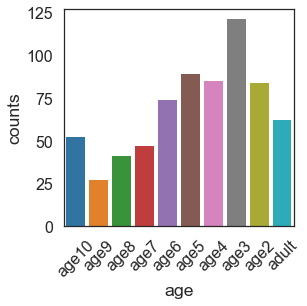

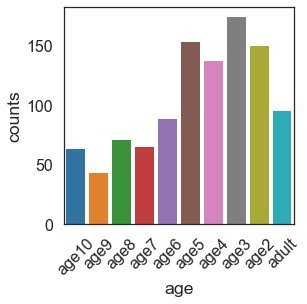

In [20]:
# df.loc[df['column_name'] == some_value]
bike = C.loc[C['category']=="a rabbit"]
plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
g=sns.barplot(data=bike,x='age',y='counts')
for item in g.get_xticklabels():
    item.set_rotation(45)
    
    
couch = C.loc[C['category']=="a dog"]
plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
g=sns.barplot(data=couch,x='age',y='counts')
for item in g.get_xticklabels():
    item.set_rotation(45)

### Render out images from museum station -- takes a *long* time.

In [ ]:
### Notes: It won't write out an image if it already exists. 
# Every time I get through a certain set of the  images, I record the time threshold 
#(since images are written out in chronological order)

## Time stamps every 100 images.
# [1525899407923.0,
#  1525980096385.0,
#  1526061840113.0,
#  1526072921014.0,
#  1526152365279.0,
#  1526160570739.0,
#  1526239856392.0,
#  1526251698552.0,
#  1526254954475.0,
#  1526418747635.0,
#  1526495927262.0,
#  1526503859627.0,
#  1526581190700.0,
#  1526593428928.0,
#  1526666014298.0,
#  1526680293892.0,
#  1526760285554.0,
#  1526766056162.0,
#  1527018277044.0,
#  1527793231321.0,
#  1527881543709.0,
#  1527960926822.0,
#  1527970125532.0,
#  1527977827733.0,
#  1527982709894.0,
#  1528059661642.0,
#  1528064507404.0,
#  1528068114827.0,
#  1528140581078.0,
#  1528225691857.0,
#  1528238270169.0,
#  1528321410290.0,
#  1528396097251.0,
#  1528409134891.0,
#  1528482501089.0,
#  1528492105365.0,
#  1528501366255.0,
#  1528579092501.0,
#  1528584985113.0,
#  1528661341497.0,
#  1528741749248.0,
#  1528747687974.0,
#  1528761045959.0,
#  1528835768499.0,
#  1528841240592.0,
#  1528916818096.0,
#  1528923498102.0,
#  1529005606993.0,
#  1529015740138.0,
#  1529092461367.0,
#  1529102005265.0,
#  1529178354515.0,
#  1529183429730.0,
#  1529190138056.0,
#  1529272790915.0,
#  1529351265769.0,
#  1529360098520.0,
#  1529435563121.0,
#  1529443877705.0,
#  1529518216924.0,
#  1529529413026.0,
#  1529690851878.0,
#  1529705056613.0,
#  1530311006680.0]


In [7]:
# time_threshold = 1530650649659.0 ## first ~7000 images!
time_threshold = 1533252327962.0 ## all images up until morning of Aug 3

before_thres = coll.find({'time':{'$lt': time_threshold}}).distinct('sessionId') 
after_thres = coll.find({'time':{'$gt': time_threshold}}).distinct('sessionId') 
image_recs = coll.find({'$and': [{'time': {'$gt': time_threshold}}, 
                                            {'dataType':'finalImage'}]}).sort('time')    
print('we have {} valid sessions before time threshold'.format(len(before_thres)))
print('we have {} valid sessions after time threshold'.format(len(after_thres)))
print('we have {} images after time threshold'.format(image_recs.count()))
##

we have 3020 valid sessions before time threshold
we have 1393 valid sessions after time threshold
we have 8737 images after time threshold


In [8]:
really_run_this=1
skipCount = 0;
writeImageCount = 0;
timeSave = []
valid_sessions = after_thres;

if really_run_this:
    imsize = 224 ## img writing size, optimized for CNN
    for s in valid_sessions:
        this_collection = coll
        image_recs = this_collection.find({'$and': [{'sessionId':s}, {'dataType':'finalImage'}]}).sort('time')    
#         print('In the {} session we have {} images'.format(s,image_recs.count()))
        if image_recs.count()>3:
            for imrec in image_recs:                                                            
                category_dir = os.path.join(sketch_dir,imrec['category'])
                if not os.path.exists(category_dir):
                    os.makedirs(category_dir)
                fname = os.path.join(category_dir,'{}_sketch_{}_{}.png'.format(imrec['category'], imrec['age'],imrec['sessionId']))
                if os.path.isfile(fname):
                    ## skip this image!
                    skipCount = skipCount + 1;
                    if np.mod(skipCount,100)==0:
                        print('Weve skipped {} images...'.format(skipCount))
                        timeSave.append(imrec['time']) # we're writing out in order of time, so we can save these thresholds to be more efficeint later
                else:
                    stroke_recs = this_collection.find({'$and': [{'sessionId':s}, 
                                      {'dataType':'stroke'},
                                      {'trialNum': imrec['trialNum']}]}).sort('time')   
                    if stroke_recs.count() > 0 and imrec['age']!='adult':
                        imgData = imrec['imgData'];
                        writeImageCount = writeImageCount+1
                        with open(fname, "wb") as fh:
                            fh.write(imgData.decode('base64'))   
                        if np.mod(writeImageCount,10)==0:
                            print('Weve written {} images...'.format(writeImageCount))
                            timeSave.append(imrec['time'])

Weve skipped 100 images...
Weve skipped 200 images...
Weve skipped 300 images...
Weve skipped 400 images...
Weve skipped 500 images...
Weve skipped 600 images...
Weve skipped 700 images...
Weve skipped 800 images...
Weve skipped 900 images...
Weve skipped 1000 images...
Weve skipped 1100 images...
Weve skipped 1200 images...
Weve skipped 1300 images...
Weve skipped 1400 images...
Weve skipped 1500 images...
Weve skipped 1600 images...
Weve skipped 1700 images...
Weve skipped 1800 images...
Weve skipped 1900 images...
Weve skipped 2000 images...
Weve skipped 2100 images...
Weve skipped 2200 images...
Weve skipped 2300 images...
Weve skipped 2400 images...
Weve skipped 2500 images...
Weve skipped 2600 images...
Weve skipped 2700 images...
Weve skipped 2800 images...
Weve skipped 2900 images...
Weve skipped 3000 images...
Weve skipped 3100 images...
Weve skipped 3200 images...
Weve skipped 3300 images...
Weve skipped 3400 images...
Weve skipped 3500 images...
Weve skipped 3600 images...
W

In [10]:
timeSave[-1]
#  1536096511143.0

1536096511143.0

### Writes out images and gets other kinds of info...

In [2]:
# really_run_this =  0
# if really_run_this:
#     ## img writing parameters
#     imsize = 224
    
#     ## desired output: a dataframe that has trials on the rows, and the following columns:
#     ## category, age, number of strokes, mean_pixel_intensity, bounding_box_coordinates_LTRB, list of strokes, 
#     ## PNG string, submission_time, submission_date
#     ## to be saved out as a nice tidy CSV
#     session_id = []
#     trial_num = []
#     category = []
#     age = []
#     num_strokes = []
#     mean_pixel_intensity = []
#     bounding_box_coords = []
#     svg = []
#     svg_times = []
#     png = []
#     submit_time = []
#     submit_date = []
#     submit_date_readable = []
#     draw_duration = []
#     filename = []
#     for s in valid_sessions:
#         this_collection = coll
#         image_recs = this_collection.find({'$and': [{'time': {'$gt': time_threshold}}, {'sessionId':s}, {'dataType':'finalImage'}]}).sort('time')    
#         for imrec in image_recs:                                                            
#                 stroke_recs = this_collection.find({'$and': [{'time': {'$gt': time_threshold}}, 
#                                                   {'sessionId':s}, 
#                                                   {'dataType':'stroke'},
#                                                   {'trialNum': imrec['trialNum']}]}).sort('time')   

#                 if 'age' in imrec.keys():
#                     if imrec['age'] != 'adult':
                        
#                         os.path.isfile(path)
                        
#                         if stroke_recs.count() > 0: ## only include trials if the drawings are not blank   
                            
                           
                            
#                             session_id.append(imrec['sessionId'])        
#                             trial_num.append(imrec['trialNum']) 
#                             category.append(imrec['category'])
#                             age.append(imrec['age'])
                            
#                             png.append(imrec['imgData'])
#                             submit_time.append(imrec['time'])
#                             readadble_date = datetime.datetime.fromtimestamp(imrec['time']/1000.0).strftime('%Y-%m-%d %H:%M:%S.%f')
#                             submit_date_readable.append(readadble_date)
                        
#                             submit_date.append(imrec['date'])
#                             filename.append(os.path.join(sketch_dir,'{}_sketch_{}_{}.png'.format(imrec['category'], imrec['age'],imrec['sessionId'])))
#                             num_strokes.append(stroke_recs.count())
#                             _svg = [] # this keeps track of the strokes from THIS final image
#                             _svg_times = []
#                             for strec in stroke_recs:
#                                 _svg.append(strec['svg'])
#                                 _svg_times.append(strec['time'])
#                             draw_duration.append((_svg_times[-1] - _svg_times[0])/1000) ## in seconds
#                             svg.append(_svg)
#                             svg_times.append(_svg_times)

#                             ## and write out image data here too
#                             imgData = imrec['imgData'];
#                             filestr = base64.b64decode(imgData)
#                             category_dir = os.path.join(sketch_dir,imrec['category'])
#                             if not os.path.exists(category_dir):
#                                 os.makedirs(category_dir)
#                             fname = os.path.join(category_dir,'{}_sketch_{}_{}.png'.format(imrec['category'], imrec['age'],imrec['sessionId']))
#                             with open(fname, "wb") as fh:
#                                 fh.write(imgData.decode('base64'))  
                        

In [61]:
# really_run_this = 1
# if really_run_this:
#     ## img writing parameters
#     imsize = 224
    
#     ## desired output: a dataframe that has trials on the rows, and the following columns:
#     ## category, age, number of strokes, mean_pixel_intensity, bounding_box_coordinates_LTRB, list of strokes, 
#     ## PNG string, submission_time, submission_date
#     ## to be saved out as a nice tidy CSV
#     session_id = []
#     trial_num = []
#     category = []
#     age = []
#     num_strokes = []
#     mean_pixel_intensity = []
#     bounding_box_coords = []
#     svg = []
#     svg_times = []
#     png = []
#     submit_time = []
#     submit_date = []
#     submit_date_readable = []
#     draw_duration = []
#     filename = []
    
#     for cat in ['a boat','a car','a cup','a dog','a fish','a house','a person','a tree']:
#         imgcount = 0
#         this_collection = coll
#         image_recs = this_collection.find({'$and': [{'time': {'$gt': time_threshold}}, {'category':cat},{'dataType':'finalImage'}]}).sort('time')   
#         for imrec in image_recs:  
#                 if imgcount < 100:
#                     stroke_recs = this_collection.find({'$and': [{'time': {'$gt': time_threshold}}, 
#                                                       {'sessionId':imrec['sessionId']}, 
#                                                       {'dataType':'stroke'},
#                                                       {'trialNum': imrec['trialNum']}]}).sort('time')   

#                     if 'age' in imrec.keys():
#                         if imrec['age'] != 'adult':
#                             if stroke_recs.count() > 0: ## only include trials if the drawings are not blank    
#                                 imgcount += 1
#                                 session_id.append(imrec['sessionId'])        
#                                 trial_num.append(imrec['trialNum']) 
#                                 category.append(imrec['category'])
#                                 age.append(imrec['age'])

#                                 png.append(imrec['imgData'])
#                                 submit_time.append(imrec['time'])
#                                 readadble_date = datetime.datetime.fromtimestamp(imrec['time']/1000.0).strftime('%Y-%m-%d %H:%M:%S.%f')
#                                 submit_date_readable.append(readadble_date)

#                                 submit_date.append(imrec['date'])
#                                 filename.append(os.path.join(sketch_dir,'{}_{}.png'.format(imrec['category'], imgcount)))
#                                 num_strokes.append(stroke_recs.count())
#                                 _svg = [] # this keeps track of the strokes from THIS final image
#                                 _svg_times = []
#                                 for strec in stroke_recs:
#                                     _svg.append(strec['svg'])
#                                     _svg_times.append(strec['time'])
#                                 draw_duration.append((_svg_times[-1] - _svg_times[0])/1000) ## in seconds
#                                 svg.append(_svg)
#                                 svg_times.append(_svg_times)

#                                 ## and write out image data here too
#                                 imgData = imrec['imgData'];
#                                 filestr = base64.b64decode(imgData)
#                                 category_dir = os.path.join(sketch_dir,imrec['category'])
#                                 if not os.path.exists(category_dir):
#                                     os.makedirs(category_dir)
#                                 fname = os.path.join(category_dir,'{}_{}.png'.format(imrec['category'],imgcount))
#                                 with open(fname, "wb") as fh:
#                                     fh.write(imgData.decode('base64'))  


In [ ]:
# submit_date_readable[-100]

In [62]:
# if really_run_this:
#     X = pd.DataFrame([category,age,num_strokes,filename])
#     X = X.transpose()
#     X.columns = ['category','age','num_strokes', 'filename']
#     X.to_csv("scribble_annotate.csv")

In [ ]:
# if really_run_this:
#     X_out = pd.DataFrame([session_id,trial_num,category,age,submit_time,submit_date,num_strokes,draw_duration,filename])
#     X_out = X_out.transpose()
#     X_out.columns = ['session_id','trial_num','category','age','submit_time','submit_date','num_strokes','draw_duration', 'filename']

#     X_out.to_csv('May31th_usage.csv')

In [ ]:
# def get_bounding_box(img):
#     rows = np.any(img, axis=1)
#     cols = np.any(img, axis=0)
#     rmin, rmax = np.where(rows)[0][[0, -1]]
#     cmin, cmax = np.where(cols)[0][[0, -1]]
#     return rmin, rmax, cmin, cmax

# merged_experiment_name = 'E1cd'

# if really_run_this:

#     ## add mean pixel intensity (amount of ink spilled) & bounding box coords 
#     mean_intensity = []
#     bounding_box = []
#     imsize = 100
#     numpix = imsize**2
#     thresh = 250
#     for i,_d in X.iterrows():
#         imgData = _d['png']
#         filestr = base64.b64decode(imgData)
#         fname = os.path.join('sketch.png')
#         with open(fname, "wb") as fh:
#             fh.write(imgData.decode('base64'))
#         im = Image.open(fname).resize((imsize,imsize))
#         _im = np.array(im)
#         mean_intensity.append(len(np.where(_im[:,:,3].flatten()>thresh)[0])/numpix)
#         # bounding box part
#         rmin, rmax, cmin, cmax = get_bounding_box(np.array(Image.open(fname)))
#         bounding_box.append(tuple((rmin, rmax, cmin, cmax)))

#     ## add to dataframe    
#     X = X.assign(mean_intensity=pd.Series(mean_intensity).values)
#     X = X.assign(bounding_box=pd.Series(bounding_box).values)
    
#     # save out csv
#     if not os.path.exists('../preprocessed_data'):
#         os.makedirs('../preprocessed_data')
#     X.to_csv('../preprocessed_data/museumdraw_{}_data.csv'.format(merged_experiment_name))


### load drawing metadata csv back in

In [ ]:
plt.hist(X.age,normed=False)
plt.xticks(rotation=90)
len(X.age)
sum(X.age != 'adult')

### Basic visualizations

In [ ]:
np.sum(X.draw_duration.values>25)

In [ ]:
fig = plt.figure(figsize=(4,4))
h = plt.hist(X.num_strokes.values,normed=True)
plt.ylabel('proportion')
plt.xlabel('number of strokes')

In [ ]:
fig = plt.figure(figsize=(4,4))
h = plt.hist(X.draw_duration.values,normed=True)
plt.ylabel('proportion')
plt.xlabel('draw duration')

In [ ]:
plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
seq = np.arange(4,10)
sns.barplot(data=X,x='age',y='num_strokes',order=seq,palette="Greens_d")
plt.ylabel('number of strokes')

plt.subplot(1,3,2)
seq = np.arange(4,10)

sns.barplot(data=X,x='age',y='draw_duration',order=seq, palette="Greens_d")
plt.ylabel('draw duration (s)')

# plt.subplot(1,3,3)
# seq = np.arange(4,10)
# sns.barplot(data=X,x='age',y='mean_intensity',order=seq,palette="Greens_d")
# plt.ylabel('mean pixel intensity')

plt.tight_layout()

In [ ]:
unique = X.drop_duplicates(["session_id"])
unique.count()
# sum(unique.age != 'adult')
sum(unique.age != 'adult')